# Comparison of the normalized activation length with the equality in distribution result and the formula for the mean

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.filters import gaussian_filter

%matplotlib inline
np.random.seed(7726)

COLOR_LIST = ['xkcd:blue', 'xkcd:red', 'xkcd:irish green', 'xkcd:yellow orange']

In [2]:
K = 5
WIDTH = 10
WEIGHT_SAMPLES = 1000
L_PRIME_ARR = [5, 10, 15, 20, 25, 30, 35, 40]
c = 0.55555 # The values suggested in the paper for maxout rank K = 5

input_x = np.random.normal(loc=0., scale=1., size=[WIDTH])
input_x = input_x / np.linalg.norm(input_x)

# Actual value

In [3]:
al_mean = []
al_2nd = []
al_std = []
for l_prime in L_PRIME_ARR:
    print(f'l_prime: {l_prime}')
    lal_arr = []
    for _ in range(WEIGHT_SAMPLES):
        xl = input_x
        for l in range(l_prime):
            weights = np.random.normal(loc=0., scale=np.sqrt(c / WIDTH), size=[WIDTH, K, WIDTH])
            biases = np.random.normal(loc=0., scale=np.sqrt(c / WIDTH), size=[WIDTH, K])
            xl = np.max(np.dot(weights, xl) + biases, axis=-1)
        lal_arr.append((np.linalg.norm(xl)**2) / WIDTH)
    
    al_mean.append(np.mean(lal_arr))
    al_2nd.append(np.mean(np.asarray(lal_arr)**2))
    al_std.append(np.std(lal_arr))
al_mean = np.asarray(al_mean)
al_2nd = np.asarray(al_2nd)
al_std = np.asarray(al_std)

l_prime: 5
l_prime: 10
l_prime: 15
l_prime: 20
l_prime: 25
l_prime: 30
l_prime: 35
l_prime: 40


# Estimated value

In [4]:
def get_gaussian_los(sample_size):
    return np.max(np.random.normal(loc=0., scale=1., size=[sample_size]))

def get_gaussian_los_sum(sample_size, n):
    return np.sum([get_gaussian_los(sample_size)**2 for _ in range(n)])

def get_prod(sample_size, n, start, end):
    return np.prod([get_gaussian_los_sum(sample_size, n) * c / WIDTH for _ in range(start, end)])

frak_x = np.asarray(list(input_x) + [1])
frak_x_norm_sq = np.linalg.norm(frak_x)**2
 
est_al_mean = []
est_al_2nd = []
est_al_std = []
for l_prime in L_PRIME_ARR:
    print(f'l_prime: {l_prime}')
    est_lal_arr = []
    for _ in range(WEIGHT_SAMPLES):        
        ####################################################        
        layer_xi_arr = [[-1000000 for _ in range(WIDTH)] for _ in range(l_prime)]
        for l in range(l_prime):
            for i in range(WIDTH):
                layer_xi_arr[l][i] = np.max(np.random.normal(loc=0., scale=1., size=K))**2
        
        summand1 = frak_x_norm_sq / WIDTH
        for l in range(l_prime):
            local_sum = 0
            for i in range(WIDTH):
                local_sum += layer_xi_arr[l][i]
            summand1 *= local_sum * c / WIDTH
            
        summand2 = 0
        for j in range(1,l_prime):
            local_prod = 1 / WIDTH
            for l in range(j, l_prime):                
                local_sum = 0
                for i in range(WIDTH):
                    local_sum += layer_xi_arr[l][i]
                local_prod *= local_sum * c / WIDTH
            summand2 += local_prod
        ####################################################
        est_lal_arr.append(summand1 + summand2)
        
    est_al_mean.append(np.mean(est_lal_arr))
    est_al_2nd.append(np.mean(np.asarray(est_lal_arr)**2))
    est_al_std.append(np.std(est_lal_arr))
    
est_al_mean = np.asarray(est_al_mean)
est_al_2nd = np.asarray(est_al_2nd)
est_al_std = np.asarray(est_al_std)

l_prime: 5
l_prime: 10
l_prime: 15
l_prime: 20
l_prime: 25
l_prime: 30
l_prime: 35
l_prime: 40


# Formula

In [5]:
formula_al_mean = []
for l_prime in L_PRIME_ARR:
    formula_al_mean.append(frak_x_norm_sq / WIDTH * (c / 0.55555)**l_prime
                           + np.sum([((c / 0.55555)**(l_prime-j) / WIDTH) 
                                     for j in range(1, l_prime)]))

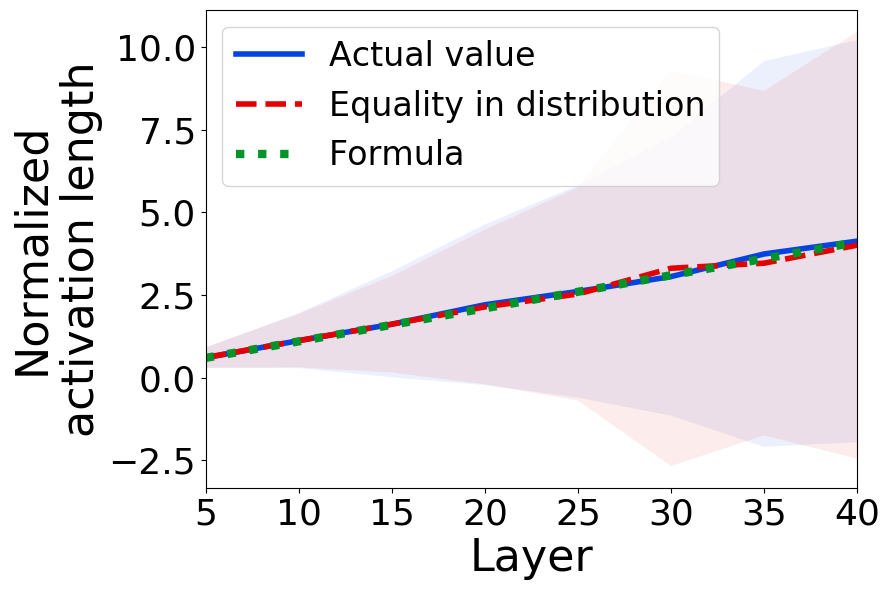

In [6]:
fig = plt.figure(figsize=(9, 6), dpi=100)
ax = fig.add_subplot(111)
ax.tick_params(axis='both', which='major', labelsize=26)
ax.tick_params(axis='both', which='minor', labelsize=26)

plt.xlabel("Layer", size=32)
plt.ylabel("Normalized\nactivation length", size=32)
plt.margins(x=0)

plt.xticks(L_PRIME_ARR)

plt.plot(L_PRIME_ARR, al_mean, color=COLOR_LIST[0], lw=4, label=f'Actual value')
plt.fill_between(L_PRIME_ARR, al_mean + al_std, al_mean - al_std, facecolor=COLOR_LIST[0], alpha=0.075)

plt.plot(L_PRIME_ARR, est_al_mean, color=COLOR_LIST[1], lw=4, ls='--',
         label=f'Equality in distribution')
plt.fill_between(L_PRIME_ARR, est_al_mean + est_al_std, est_al_mean - est_al_std,
                 facecolor=COLOR_LIST[1], alpha=0.075)

plt.plot(L_PRIME_ARR, formula_al_mean, color=COLOR_LIST[2], lw=6, ls=':', label=f'Formula')

plt.legend(loc='upper left', fontsize=24, title_fontsize=16)

plt.tight_layout()
plt.savefig(f'activation_length.png')